# XY heatmap
Show where in the arena spikes occur for each unit

In [9]:
# imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from data.dbase.db_tables import Probe, Unit, Session, ValidatedSession, Recording, Tracking
from data.data_utils import convolve_with_gaussian

from fcutils.maths.signals import get_onset_offset
from fcutils.plot.figure import clean_axes, calc_nrows_ncols
from myterial import amber_darker, green_dark, grey_darker, blue_darker, grey


save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")


# print all available recordings
print(*zip(*Recording().fetch("name", "recording_probe_configuration")), sep="\n")

('FC_210715_AAA1110750_r5_hairpin', 'longcolumn')
('FC_210716_AAA1110750_r6_hairpin', 'longcolumn')
('FC_210720_AAA1110750_hairpin', 'longcolumn')
('FC_210721_AAA1110750_hairpin', 'longcolumn')
('FC_210722_AAA1110750_hairpin', 'longcolumn')
('FC_211022_BAA110516_hairpin', 'longcolumn')
('FC_211027_BAA110516_hairpin', 'longcolumn')
('FC_211214_BAA110517_hairpin', 'b0')
('FC_220114_BAA110517_hairpin', 'b0')
('FC_220117_BAA110517_hairpin', 'b0')
('FC_220119_BAA110517_hairpin', 'b0')
('FC_220120_BAA110517_hairpin', 'b0')
('FC_210917_BAA1110279_hairpin', 'b0')
('FC_210820_BAA1110281_hairpin', 'longcolumn')
('FC_210829_BAA1110281_hairpin', 'longcolumn')
('FC_210830_BAA1110281_hairpin', 'longcolumn')
('FC_210831_BAA1110281_hairpin', 'longcolumn')
('FC_210901_BAA1110281_hairpin', 'longcolumn')
('FC_210906_BAA1110281_hairpin', 'b0')
('FC_210917_BAA1110281_hairpin', 'b0')


In [3]:
REC = "FC_210831_BAA1110281_hairpin"

metadata = pd.DataFrame(
    (Recording & f'name="{REC}"').fetch()
)

tracking = Tracking.get_session_tracking(REC, body_only=True)
print(tracking)

units = pd.DataFrame(Unit * Unit.Spikes * Probe.RecordingSite & f'name="{REC}"')
units = units.sort_values("brain_region", inplace=False).reset_index()

mouse_id                                                   BAA1110281
name                                     FC_210831_BAA1110281_hairpin
bpname                                                           body
orientation         [263.2221909712088, 248.0719881966579, 274.476...
angular_velocity    [15793.331458272529, -909.0121664730524, 1584....
speed               [16.258761509027146, 15.194170474778758, 24.01...
acceleration        [16.258761509027146, -1.0645910342483873, 8.82...
theta               [184.76008693132673, 185.31553221100674, 187.9...
thetadot            [11085.605215879603, 33.32671678080058, 159.15...
thetadotdot         [11085.605215879603, -11052.278499098802, 125....
x                   [25.49565450371506, 25.735919879747886, 25.972...
y                   [57.10009239474049, 57.010520421705436, 57.102...
bp_speed            [16.258761509027146, 15.194170474778758, 24.01...
moving              [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
walking             

## make plot

index                                                                          77
mouse_id                                                               BAA1110281
name                                                 FC_210831_BAA1110281_hairpin
unit_id                                                                       526
site_id                                                                       259
probe_configuration                                                    longcolumn
secondary_sites_ids             [241, 243, 245, 247, 249, 251, 253, 255, 257, ...
spikes_ms                       [491.41364701746267, 1093.6222313140763, 1821....
spikes                          [29, 66, 109, 115, 134, 142, 270, 296, 385, 40...
registered_brain_coordinates    [9771.406714147466, 3534.328379926737, 4257.49...
probe_coordinates                                                            2580
brain_region                                                                  CUN
brain_region_id 

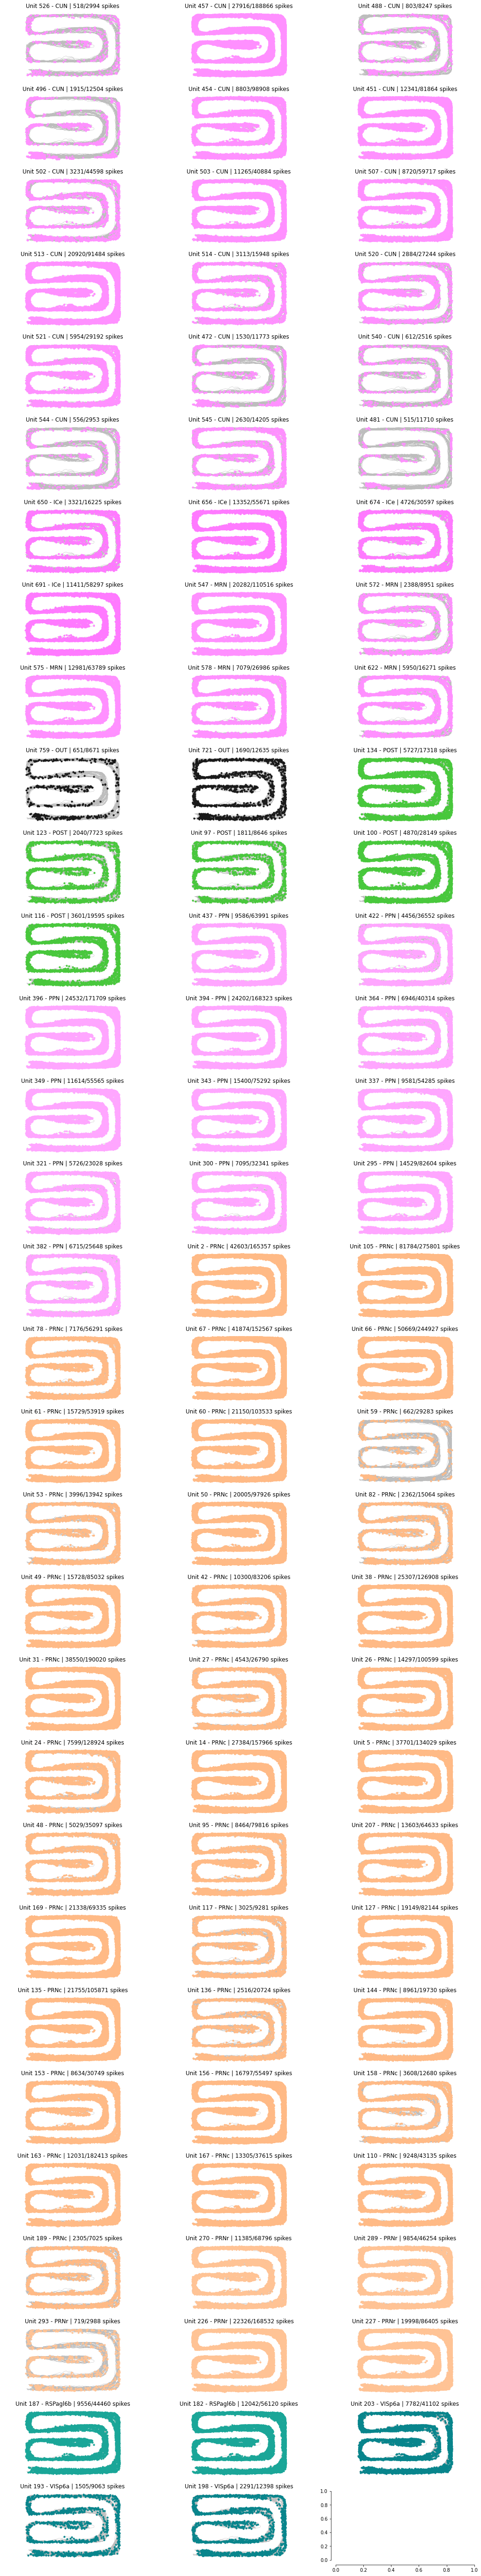

In [37]:
SPEED_TH = 10  # only show spikes when mouse is going faster than this, in cm/s




fast = np.where(tracking["speed"] > SPEED_TH)[0]

# spikes = unit.spikes



f, axes = plt.subplots(np.ceil(len(units)/3).astype(int), 3, figsize=(18, 100))
# f.suptitle(f"{REC} - locomotion onset")

for (i, unit), ax in zip(units.iterrows(), axes.flatten()):
    spikes = unit.spikes[np.isin(unit.spikes, fast)]
    ax.set(title=f"Unit {unit.unit_id} - {unit.brain_region} | {len(spikes)}/{len(unit.spikes)} spikes")


    ax.plot(tracking.y[fast], tracking.x[fast], color=grey, lw=.5)
    ax.scatter(tracking.y[spikes], tracking.x[spikes], color=unit.color, s=10, alpha=1, zorder=100)

    ax.axis("equal")
    ax.axis("off")

clean_axes(f)
f.savefig(save_folder / f"{REC}_units_xy_heatmaps.png", dpi=100, bbox_inches="tight")